# CNN LSTM Model

50.039 Theory and Practice of Deep Learning Project

In [1]:
!pip install torchinfo

In [2]:
!pip install torchinfo

import pandas as pd
import numpy as np
from torch.nn import init

import os
import sys
from tqdm import tqdm

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


from IPython.display import Audio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset,random_split,DataLoader

import pandas as pd
import numpy as np
from torchinfo import summary
from train.MelTrainHelper import TrainHelper
from inference.Infer import infer

from Preprocessor import *
import Constants

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [4]:
#Convert Dataset into Pandas Dataframe
Tess = "../data/TESS"

tess_directory_list = os.listdir(Tess)
preprocessor = DataPreprocessor()   
file_paths, labels = preprocessor.get_file_paths_and_labels(Tess)

EMOTIONS= {'neutral':0,'happy':1, 'sad':2, 'angry':3, 'fear':4, 'disgust':5, 'ps':6}
encoded_labels = [EMOTIONS[label] for label in labels]
emotion_df = pd.DataFrame(labels, columns=['Emotions'])
print("ALL EMOTIONS:", set(labels))

path_df = pd.DataFrame(file_paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

ALL EMOTIONS: {'fear', 'ps', 'sad', 'neutral', 'angry', 'happy', 'disgust'}


,Emotions,Path
0,sad,./data/TESS/YAF_sad/YAF_wife_sad.wav
1,sad,./data/TESS/YAF_sad/YAF_hate_sad.wav
2,sad,./data/TESS/YAF_sad/YAF_phone_sad.wav
3,sad,./data/TESS/YAF_sad/YAF_week_sad.wav
4,sad,./data/TESS/YAF_sad/YAF_raid_sad.wav


# Data Preprocessing

In [ ]:
SAMPLE_RATE = Constants.CNN_SAMPLING_RATE
signals = preprocessor.extract_audio_signals(Tess_df['Path'])

In [ ]:
mel_spectograms = preprocessor.extract_mel_spectograms(signals)

In [ ]:
X_train = preprocessor.reshape_scale_data(mel_spectograms)
X_test = preprocessor.reshape_scale_data(encoded_labels)

In [ ]:
with open('mel_spec_all.npy', 'wb') as f:
    np.save(f, mel_spectograms)

In [6]:
with open('mel_spec_all.npy', 'rb') as f:
    mel_spectograms = np.load(f)

In [7]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = preprocessor.train_val_test_split(mel_spectograms, encoded_labels)

In [8]:
X_train = preprocessor.reshape_scale_data(X_train)
X_test = preprocessor.reshape_scale_data(X_test)
X_val = preprocessor.reshape_scale_data(X_val)

# Create the model

In [9]:
class CNN_LSTM(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        hidden_size = 128
        
        conv2d_1 = nn.Conv2d(in_channels=1, out_channels=16, stride=1, padding=1, kernel_size=3)
        conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, padding=1, kernel_size=3)
        conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, padding=1, kernel_size=3)
        conv2d_4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, padding=1, kernel_size=3)
        relu = nn.ReLU()
        maxPool2_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        maxPool4_4 = nn.MaxPool2d(kernel_size=4, stride=4)
        dropOut = nn.Dropout(p=0.1)
        batchNorm16 = nn.BatchNorm2d(16)
        batchNorm32 = nn.BatchNorm2d(32)
        batchNorm64 = nn.BatchNorm2d(64)
        
        #Convolution Block
        self.conv2Dblock = nn.Sequential(conv2d_1, batchNorm16, relu, maxPool2_2, dropOut,
                                         conv2d_2, batchNorm32, relu, maxPool4_4, dropOut,
                                         conv2d_3, batchNorm64, relu, maxPool4_4, dropOut,
                                         conv2d_4, batchNorm64, relu, maxPool4_4, dropOut)
        
        #LSTM Block
        self.maxpool_lstm = nn.MaxPool2d(stride=[2,4], kernel_size=[2,4])
        self.lstm = nn.LSTM(input_size=64,
                            bidirectional=True,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.dropout_lstm = nn.Dropout(0.1)
        self.attention_linear = nn.Linear(2*hidden_size,1)
        self.out_linear = nn.Linear(2*hidden_size+256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0.1)
        self.out_softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        #Convolutional
        conv_out = self.conv2Dblock(x)
        conv_out = torch.flatten(conv_out, start_dim=1)
        #LSTM
        x_maxpool = self.maxpool_lstm(x)
        x_squeeze = torch.squeeze(x_maxpool,1)
        x_permute = x_squeeze.permute(0,2,1)
        lstm_out, (h,c) = self.lstm(x_permute)
        lstm_out = self.dropout_lstm(lstm_out)
        batch_size, T, _ = lstm_out.shape 
        attention_weights = [None]*T
        for t in range(T):
            embedding = lstm_out[:,t,:]
            attention_weights[t] = self.attention_linear(embedding)
        attention_weights_norm = nn.functional.softmax(torch.stack(attention_weights,-1),-1)
        attention = torch.bmm(attention_weights_norm,lstm_out)
        attention = torch.squeeze(attention, 1)
        # Concatenate CNN & LSTM Part
        complete_out = torch.cat([conv_out, attention], dim=1) 
        
        output_logits = self.out_linear(complete_out)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax #, attention_weights_norm

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# TRAINING

In [7]:
train_helper = TrainHelper()
model = CNN_LSTM(num_emotions=7).to(device)
epochs= 150
batch_size = 32
model, losses, train_accuracies, val_losses, val_accuracies = train_helper.model_train(model, epochs, batch_size, X_train, Y_train, X_val, Y_val, 'cuda', 0.0001, optimizer="Adam")

Number of trainable params:  262952
 Epoch 0: iteration 69/70
Epoch 0 --> loss:1.7110, acc:47.68%, val_loss:1.5255, val_acc:77.50%
 Epoch 1: iteration 69/70
Epoch 1 --> loss:1.4613, acc:75.04%, val_loss:1.4179, val_acc:84.64%
 Epoch 2: iteration 69/70
Epoch 2 --> loss:1.3319, acc:87.01%, val_loss:1.3484, val_acc:86.43%
 Epoch 3: iteration 69/70
Epoch 3 --> loss:1.2595, acc:93.48%, val_loss:1.2614, val_acc:93.21%
 Epoch 4: iteration 69/70
Epoch 4 --> loss:1.2259, acc:95.45%, val_loss:1.2817, val_acc:90.36%
 Epoch 5: iteration 69/70
Epoch 5 --> loss:1.2112, acc:96.43%, val_loss:1.2077, val_acc:97.86%
 Epoch 6: iteration 69/70
Epoch 6 --> loss:1.2103, acc:96.03%, val_loss:1.2232, val_acc:97.14%
 Epoch 7: iteration 69/70
Epoch 7 --> loss:1.2038, acc:96.83%, val_loss:1.1923, val_acc:98.57%
 Epoch 8: iteration 69/70
Epoch 8 --> loss:1.2011, acc:96.83%, val_loss:1.2091, val_acc:98.21%
 Epoch 9: iteration 69/70
Epoch 9 --> loss:1.1960, acc:97.46%, val_loss:1.1980, val_acc:97.50%
 Epoch 10: ite

KeyboardInterrupt: 

# Saving the trained model's weights

In [12]:
saved_trained_weights_file = "PCNN_LSTM_150e_32b_dp0.1_lr0.1.pt"

os.makedirs('models', exist_ok=True)
file_path = os.path.join(os.getcwd(),'models')
torch.save(trained_model.state_dict(), os.path.join(file_path, saved_trained_weights_file))
print('Trained Weights saved to'.format(os.path.join(file_path, saved_trained_weights_file)))

Trained Weights saved to


# Loading model's weights

In [11]:
loaded_trained_weights_file = "PCNN_LSTM_150e_32b_dp0.4.pt"

LOAD_PATH = os.path.join(os.getcwd(),'models')
model = CNN_LSTM(len(EMOTIONS))
model.load_state_dict(torch.load(os.path.join(LOAD_PATH, loaded_trained_weights_file)))
print('Weights for Model is loaded from {}'.format(os.path.join(LOAD_PATH, loaded_trained_weights_file)))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/50.039-Deep-Learning-Project-Tonality-Recognition/models/PCNN_LSTM_150e_32b_dp0.4.pt'

In [63]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN_LSTM                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Dropout: 2-5                      --
│    └─Conv2d: 2-6                       4,640
│    └─BatchNorm2d: 2-7                  64
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Dropout: 2-10                     --
│    └─Conv2d: 2-11                      18,496
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Dropout: 2-15                     --
│    └─Conv2d: 2-16                      36,928
│    └─BatchNorm2d: 2-17                 (recursive)
│    └─ReLU: 2-18                        --
│    └─MaxPool2d: 2-19                   --
│    

# Testing

In [19]:
validate = train_helper.make_validate_func(model, train_helper.loss_func)
X_test_tensor = torch.tensor(X_test,device="cpu").float()
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long, device="cpu")
testing_loss, testing_acc, predictions = validate(X_test_tensor,Y_test_tensor)
print(f'Testing loss is {testing_loss:.6f}')
print(f'Testing accuracy is {testing_acc:.6f}%')

Testing loss is 1.172433
Testing accuracy is 99.285713%


# Confusion Matrix

In [15]:
predictions = predictions.cpu().numpy()
cm = confusion_matrix(Y_test, predictions)
print(EMOTIONS)
EMOTIONS= {0:'neutral',1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'disgust', 6:'ps'}
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

# Plot loss

In [15]:
def generate_plot(train, val, filename, typ='loss', model='MLP', savepath='figs/'):
    if len(train) != len(val):
        raise Exception("Input data arrays of different length.")
    
    # params
    nepochs = len(train)
    title_fontsize = '18'
    label_fontsize = '15'
    xtick_fontsize = '14'
    ytick_fontsize = '14'
    
    fig = plt.figure(figsize=(8,6))
    x = np.arange(nepochs)
    
    plt.plot(x, train, label='train')
    plt.plot(x, val, label='val')
    
    if typ == 'loss':
        title = 'Training and Validation Loss'
        ylabel = 'Loss Value'
    elif typ == 'acc':
        title = 'Training and Validation Accuracy'
        ylabel = 'Accuracy'
        
    title = title + ' ' + '(' + model + ')'
        
    xlabel = 'Epochs'
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.legend(fontsize=ytick_fontsize, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
    plt.savefig('./Figs/' + filename + '.png', dpi=250)
    plt.show()

In [16]:
generate_plot(losses,val_losses,"File",'loss',"Model",'figs/')

NameError: name 'losses' is not defined

# Visualizing mel spectrograms

In [13]:
audio = preprocessor.extract_audio_signals(["./data/TESS/YAF_happy/YAF_wife_happy.wav"])
Audio(audio,rate=48000)


 extract_audio_signals: Processed 0/1 files

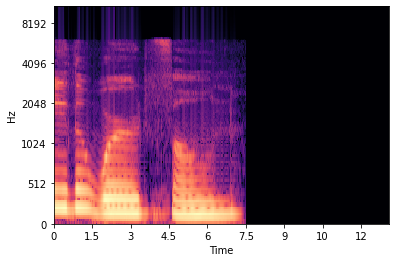

In [14]:
librosa.display.specshow(mel_spectograms[2].squeeze(), y_axis='mel', x_axis='time',cmap='magma')
Audio(audio,rate=48000)

# Inferring Single or Multiple Samples

In [21]:
#Inferring Single Sample
single_test = "../data/TESS/YAF_sad/YAF_wife_sad.wav"
infer(model,[single_test],mel_spectograms)
audio = preprocessor.extract_audio_signals([single_test])
Audio(audio,rate=48000)

Audio File:  ./TESS/YAF_sad/YAF_wife_sad.wav
Predicted Emotions:  sad 	| Ground Truth:  sad
Top 1:  sad Prob:  99.999 % 	| Top 2:  neutral Prob:  0.0 % 	| Top 3:  angry Prob:  0.0 %
 extract_audio_signals: Processed 0/1 files

In [20]:
#Inferring a list of Samples
file_ls = ["../data/TESS/YAF_sad/YAF_wife_sad.wav","../data/TESS/YAF_fear/YAF_wife_fear.wav","../data/TESS/YAF_happy/YAF_wife_happy.wav","../data/TESS/YAF_neutral/YAF_wife_neutral.wav"]
infer(model, file_ls ,mel_spectograms)

 extract_mel_spectograms: Processed 3/4 files

Audio File:  ./TESS/YAF_sad/YAF_wife_sad.wav
Predicted Emotions:  sad 	| Ground Truth:  sad
Top 1: sad (Prob: 100.0 %) 	| Top 2: neutral (Prob: 0.0 %) 	| Top 3: angry (Prob: 0.0 %)

Audio File:  ./TESS/YAF_fear/YAF_wife_fear.wav
Predicted Emotions:  fear 	| Ground Truth:  fear
Top 1: fear (Prob: 100.0 %) 	| Top 2: angry (Prob: 0.0 %) 	| Top 3: sad (Prob: 0.0 %)

Audio File:  ./TESS/YAF_happy/YAF_wife_happy.wav
Predicted Emotions:  happy 	| Ground Truth:  happy
Top 1: happy (Prob: 100.0 %) 	| Top 2: disgust (Prob: 0.0 %) 	| Top 3: angry (Prob: 0.0 %)

Audio File:  ./TESS/YAF_neutral/YAF_wife_neutral.wav
Predicted Emotions:  neutral 	| Ground Truth:  neutral
Top 1: neutral (Prob: 100.0 %) 	| Top 2: ps (Prob: 0.0 %) 	| Top 3: angry (Prob: 0.0 %)

